In [328]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import plot_roc_curve

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import NMF, PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, precision_score, 
                                    recall_score, accuracy_score, r2_score, 
                                    plot_confusion_matrix)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, plot_confusion_matrix
from sklearn.cluster import DBSCAN

from sklearn import (
    cluster, decomposition, ensemble, manifold, 
    random_projection, preprocessing)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# from sklearn.neighbors import KNeighborsRegressor

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random

## Functions

In [2]:
def plot_word_cloud(text, title, save_fig = False, f_name = None):
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    if save_fig:
        plt.savefig(f_name)
        
        
        

def plot_roc_curves_get_score_data(X_test, y_test, models, ax= plt):
    '''
    parameters:
    models is a list of sklearn models
    
    ax allows plotting on same ax
    
    returns:
    roc plot
    mse_scores 
    confusion_matrices 
    
    '''
    con_f = []
    acc_scores = []
    for model in models:
        y_pred = model.predict(X_test) 
        s = accuracy_score(y_test, y_pred)
        [[tn, fp], [fn, tp]] = confusion_matrix(y_test, y_pred)
        con_f.append([[tn, fp], [fn, tp]])
        acc_scores.append(s)
        plot_roc_curve(model, X_test, y_test, ax= ax)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    return acc_scores, con_f


def get_feature_importance(fit_model):
    feature_importances = fit_model.feature_importances_
    return feature_importances

'''
specific code for "active" found below!
'''
# feature_importances = np.argsort(gb.feature_importances_)
# df.drop(['active'], axis = 1, inplace = True)
# features = df.columns[feature_importances]

# fig, axs = plt.subplots(figsize=(10,10))
def plot_partial_dep(X_train, feature_importances, features, model):
    plt.subplots_adjust(wspace=0.8, hspace=0.8,)
    plot_partial_dependence(model, X_train, feature_importances, ax = axs, feature_names = features)
#     plt.savefig('partial_dependence_plots.png')
    

def gridsearch_with_output(estimator, parameter_grid, X_train, y_train):
    '''
        Parameters: estimator: the type of model (e.g. RandomForestRegressor())
                    paramter_grid: dictionary defining the gridsearch parameters
                    X_train: 2d numpy array
                    y_train: 1d numpy array
        Returns:  best parameters and model fit with those parameters
    '''
    model_gridsearch = GridSearchCV(estimator,
                                    parameter_grid,
                                    n_jobs=-1,
                                    verbose=True,
                                    scoring='accuracy')
    model_gridsearch.fit(X_train, y_train)
    best_params = model_gridsearch.best_params_ 
    model_best = model_gridsearch.best_estimator_
    print("\nResult of gridsearch:")
    print("{0:<20s} | {1:<8s} | {2}".format("Parameter", "Optimal", "Gridsearch values"))
    print("-" * 55)
    for param, vals in parameter_grid.items():
        print("{0:<20s} | {1:<8s} | {2}".format(str(param), 
                                                str(best_params[param]),
                                                str(vals)))
    return best_params, model_best


### Sample DF

In [51]:
df = pd.read_csv('../../cleaned_comments.csv')

In [52]:
sample_df= df.sample(frac=1/2)


In [95]:
#Utilize 1/15 of data
# sample_df = pd.read_csv('../../sample_df.csv')

In [55]:
X = sample_df.text
y = sample_df.rating

In [56]:
 y.value_counts()[0]/(y.value_counts()[1] + y.value_counts()[0])

0.06696945606416596

### VECTORIZE AND VISUALIZE

In [ ]:
# get indices of words with highest tfidf values
snowball = SnowballStemmer(language = 'english')
port = PorterStemmer()
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', analyzer='word', strip_accents='ascii',sublinear_tf = True)
txt_vect = vectorizer.fit_transform(X)
features = vectorizer.get_feature_names()

approved_features = txt_vect.toarray()[sample_df['rating']==0].mean(axis=0)
rejected_features = txt_vect.toarray()[sample_df['rating']==1].mean(axis=0)

approved_set = set(np.array(features)[approved_features.argsort()[::-1][:100]])
rejected_set = set(np.array(features)[rejected_features.argsort()[::-1][:100]])
approved_unique = approved_set.difference(rejected_set)
rejected_unique = rejected_set.difference(approved_set)

plot_word_cloud(' '.join(approved_unique), title = 'Accepted Rating')
#                  save_fig=True, f_name = 'Accepted_wp.png')

plot_word_cloud(' '.join(rejected_unique), title = 'Rejected Rating')
#                 save_fig=True, f_name = 'Rejected_wp.png')

## Imbalance fixed through undersampling

In [225]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.rating, stratify = df.rating, test_size=0.06)
y_train.value_counts()
#Rejected values utilize only 7 percent of the overall available data

len(y_test)/(len(y_test)+len(y_train))

0.06000002214451956

In [226]:
train_df = pd.concat([X_train, y_train], axis = 1)
ap_df = train_df[train_df.rating ==1]
rej_df = train_df[train_df.rating == 0]
#check your work
ap_df.rating.value_counts(), rej_df.rating.value_counts()

(1    1584507
 Name: rating, dtype: int64,
 0    113430
 Name: rating, dtype: int64)

In [227]:
min_val = rej_df.rating.value_counts()[0]
min_val

113430

In [228]:
#try to undersampling the majority class?

r = np.random.RandomState(42)
inds = np.arange(min_val)
r.shuffle(inds)
#put indices in a random order for selection

In [229]:
rej_df1=rej_df.iloc[inds]
ap_df1=ap_df.iloc[inds]


In [230]:
fixed_train_df = pd.concat([rej_df1, ap_df1], axis = 0)

In [231]:
shuffled_df = fixed_train_df.sample(frac=1)

In [232]:
shuffled_df.rating.value_counts()

1    113430
0    113430
Name: rating, dtype: int64

In [233]:
X_train = shuffled_df.text.values
y_train = shuffled_df.rating.values

In [234]:
shuffled_df.rating.value_counts()

1    113430
0    113430
Name: rating, dtype: int64

In [235]:
len(y_test)/(len(y_train)+len(y_test))

0.3232887581695447

## Train Test Split with Vectorizing 

In [200]:
# X_train, X_test, y_train, y_test = train_test_split(sample_df.text, sample_df.rating, stratify = sample_df.rating, test_size=0.2)

In [236]:
snowball = SnowballStemmer(language = 'english')
port = PorterStemmer()
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', analyzer='word', strip_accents='ascii',sublinear_tf = True)
x_train_vect = vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names()

#### Only transform your test set on your vectorizer

In [237]:
x_test_vect = vectorizer.transform(X_test.values)

## Random Forest with Balanced Classes
x_train_vect, x_test_vect, y_train, y_test

In [238]:
model = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 1,
                               max_depth = 4, 
                               n_estimators=500, 
                              max_features = 500, 
                              min_samples_split = 2,
                              bootstrap = True,
                              min_samples_leaf = 1)
model.fit(x_train_vect, y_train)

# max_depth            | 4        | [3, 2, 4]
# min_samples_split    | 2        | [2, 4]
# min_samples_leaf     | 1        | [1, 2, 4]
# bootstrap            | True     | [True, False]

RandomForestClassifier(max_depth=4, max_features=500, n_estimators=500,
                       n_jobs=-1, random_state=1)

In [239]:
filename = 'balanced_rf_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [240]:
y_pred = model.predict(x_test_vect)

accuracy_score(y_test, y_pred), \
    precision_score(y_test, y_pred), \
           recall_score(y_test, y_pred)




(0.8920731876101459, 0.9400287311083123, 0.9446108820534116)

b4 GB: (0.8306501616546348, 0.9444945499523282, 0.8696570296465899)
aftter GB: (0.8317463129456575, 0.9446224727488, 0.8707721874888781) 
(0.8952787988839187, 0.9390361276086293, 0.9493995348174871)

full_dataset
(0.8969090428454577, 0.939293085693108, 0.9509921261711004)

In [241]:
rftn, rffp, rffn, rftp = confusion_matrix(y_test, y_pred).ravel()
rftn, rffp, rffn, rftp

(1145, 6095, 5602, 95537)

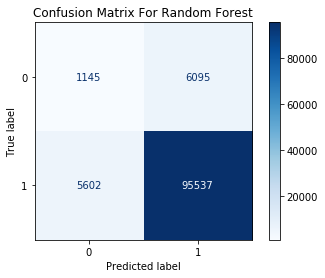

In [242]:
plot_confusion_matrix(model,x_test_vect, y_test, cmap = plt.cm.Blues)
plt.title('Confusion Matrix For Random Forest')
plt.savefig('rf_con_mx.png')
plt.show()

In [151]:
# save the model to disk

 
# some time later...
 
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

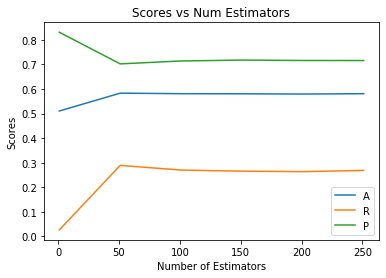

In [44]:
n_ests= np.arange(1, 300, 50)
accuracies = []
recall = []
precision = []

for n in n_ests:
    
    model = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 3,
                               max_depth = 3, 
                               n_estimators=n, 
                              max_features = 60, 
                                  )
        
    model.fit(x_train_vect, y_train)
    y_pred = model.predict(x_train_vect)
    accuracies.append(accuracy_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred))
    precision.append(precision_score(y_train, y_pred))

fig, ax = plt.subplots()
ax.plot(n_ests, accuracies, label = 'A')
ax.plot(n_ests, recall, label = 'R')
ax.plot(n_ests, precision, label = 'P')
ax.set_xlabel("Number of Estimators")
ax.set_ylabel("Scores")
ax.set_title('Scores vs Num Estimators')
# plt.savefig('RF_acur_v_feat.png')
plt.legend()
plt.show()


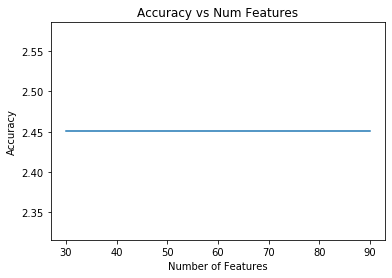

In [148]:
# num_features = np.arange(30, 100, 10)
# accuracies = []

# for n in num_features:
#     tot = 0
#     for i in range(5):
#         model = RandomForestClassifier(n_jobs=-1, 
#                                random_state  = 1,
#                                max_depth = 4, 
#                                n_estimators=500, 
#                               max_features = n)
        
#         model.fit(x_train_vect, y_train)
#         y_pred = model.predict(x_test_vect)
#         tot += accuracy_score(y_test, y_pred)
#     accuracies.append(tot)
# fig, ax = plt.subplots()
# ax.plot(num_features, accuracies)
# ax.plot
# ax.set_xlabel("Number of Features")
# ax.set_ylabel("Accuracy")
# ax.set_title('Accuracy vs Num Features')
# # plt.savefig('RF_acur_v_feat.png')
# plt.show()

## Bernoulli Naive Bayes with Balanced Classes
x_train_vect, x_test_vect, y_train, y_test

In [243]:
nb = BernoulliNB()
nb.fit(x_train_vect, y_train)

BernoulliNB()

In [244]:
filename = 'balanced_nb_model.sav'
pickle.dump(nb, open(filename, 'wb'))

In [245]:
y_pred = nb.predict(x_test_vect)

In [246]:
accuracy_score(y_test, y_pred), \
    precision_score(y_test, y_pred), \
           recall_score(y_test, y_pred)


(0.495280451009882, 0.9631387880480313, 0.47742216157960826)

In [247]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(5392, 1848, 52853, 48286)

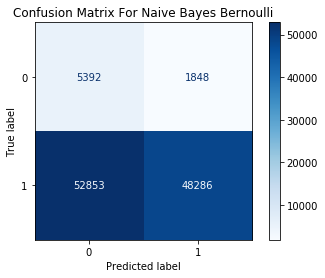

In [248]:
plot_confusion_matrix(nb,x_test_vect, y_test, cmap = plt.cm.Blues)
plt.title('Confusion Matrix For Naive Bayes Bernoulli')
plt.savefig('nb_con_mx.png')
plt.show();

Way better at predicting positives than positives 

## ComplementNB

In [249]:
from sklearn.naive_bayes import ComplementNB

In [251]:
cnb = ComplementNB()
cnb.fit(x_train_vect, y_train)
filename = 'balanced_cnb_model.sav'
pickle.dump(nb, open(filename, 'wb'))


y_pred = cnb.predict(x_test_vect)

In [252]:
accuracy_score(y_test, y_pred), \
    precision_score(y_test, y_pred), \
           recall_score(y_test, y_pred)


(0.6513715756742542, 0.9618990682550561, 0.6522508626741416)

In [253]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(4627, 2613, 35171, 65968)

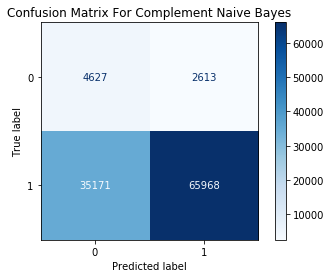

In [254]:
plot_confusion_matrix(cnb,x_test_vect, y_test, cmap = plt.cm.Blues)
plt.title('Confusion Matrix For Complement Naive Bayes')
plt.savefig('cnb_con_mx.png')
plt.show();

## Gradient Boosted Classifier Search

In [255]:
gb = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.01, random_state=0)
gb.fit(x_train_vect, y_train)


GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, random_state=0)

In [256]:
filename = 'balanced_gbst_model.sav'
pickle.dump(nb, open(filename, 'wb'))

In [257]:
y_pred = gb.predict(x_test_vect)

accuracy_score(y_test, y_pred), \
    precision_score(y_test, y_pred), \
           recall_score(y_test, y_pred)

(0.8252798051282998, 0.9466631891239853, 0.8612997953311778)

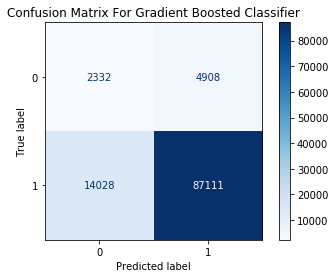

In [258]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

plot_confusion_matrix(gb,x_test_vect, y_test, cmap = plt.cm.Blues)
plt.title('Confusion Matrix For Gradient Boosted Classifier')
plt.savefig('cnb_con_mx.png')
plt.show();

lr 0.1: (0.6365428052615262, 0.9618276771773658, 0.6358060574424923)

lr 0.01: (0.8213937729748881, 0.9464234264910029, 0.8571886083006156)

## GRIDSEARCHCV

In [79]:
#RandomForest

rf_gs = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=3, max_features = 60)

random_forest_grid = {'max_depth': [3, 2, 4],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False]}
rf_best_params, rf_best_model = gridsearch_with_output(rf_gs, 
                                                       random_forest_grid, 
                                                       x_train_vect, y_train)

# gridsearch_with_output(estimator, parameter_grid, X_train, y_train):
    

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.5min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
max_depth            | 4        | [3, 2, 4]
min_samples_split    | 2        | [2, 4]
min_samples_leaf     | 1        | [1, 2, 4]
bootstrap            | True     | [True, False]


In [20]:
gb_gs = GradientBoostingClassifier(n_estimators = 500, random_state=0, learning_rate = 0.01)

gradient_boost_grid = {'warm_start':[True, False],
                        'loss' :['exponential', 'deviance'],
                      'subsample' :[1.0, 0.8, 0.5],
                      'criterion' :['friedman_mse', 'mse', 'mae'],
                     'min_impurity_decrease': [0, 0.05, 0.1]}


gb_best_params, gb_best_model = gridsearch_with_output(gb_gs, 
                                                       gradient_boost_grid, 
                                                       x_train_vect, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [113]:
# nb = BernoulliNB(alpha = 3)

bnb_gs = BernoulliNB()

gradient_boost_grid = {'alpha':[1, 3, 5, 20]}


bnb_best_params, bnb_best_model = gridsearch_with_output(bnb_gs, 
                                                       gradient_boost_grid, 
                                                       x_train_vect, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
alpha                | 1        | [1, 3, 5, 20]


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished


## Cross Valedate Test

In [123]:
sk_train_neg_rmses = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error')
sk_train_rmse = np.mean(sk_train_neg_rmses)*(-1)

In [125]:
sk_test_neg_rmses = cross_val_score(model, X_test, y_test, scoring='neg_root_mean_squared_error')
sk_test_rmse = np.mean(sk_test_neg_rmses)*(-1)

In [126]:
print(f'Sklearn train RMSE: {sk_train_rmse:0.03f}')
print(f'Sklearn test RMSE: {sk_test_rmse:0.03f}')

Sklearn train RMSE: 0.149
Sklearn test RMSE: 0.150


In [ ]:
def plot_error_vs_splitsize(X_train, y_train, n_obs_arr):
    cv_train_errors = []
    cv_test_errors = []
    for n_obs in n_obs_arr.astype('int'):
        train_error = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error')

        test_error = cross_val_score(model, X_test, y_test, scoring='neg_root_mean_squared_error')
        cv_train_errors.append(np.mean(train_error)*-1)
        cv_test_errors.append(np.mean(test_error)*-1)
    
    plt.close('all')
    
    fig, ax = plt.subplots()
    ax.plot(n_obs_arr, cv_train_errors, label='Train')
    ax.plot(n_obs_arr, cv_test_errors, label='Test')
    ax.set_xlabel('Training set size')
    ax.set_ylabel('RMSE')
    ax.legend()
    plt.show()

    
    
train_lens = np.linspace(10,100, 25)
plot_error_vs_splitsize(X_train, y_train, n_obs_arr=train_lens )


In [ ]:
tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
# (tn, fp, fn, tp)
# (0, 2, 1, 1)

## PLOT ROC CURVES ALL MODELS

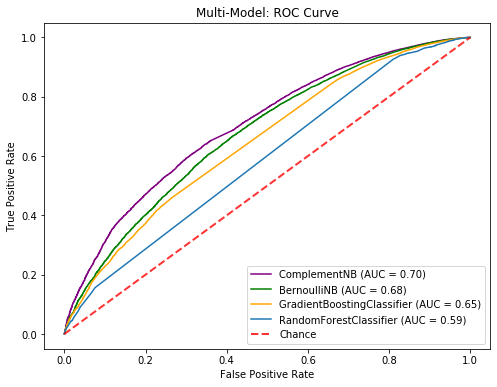

In [260]:
fig, ax = plt.subplots(1, figsize = (8,6))
plot_roc_curve(cnb, x_test_vect, y_test, ax = ax, color = 'purple')
plot_roc_curve(nb, x_test_vect, y_test, ax = ax, color = 'g')
plot_roc_curve(gb, x_test_vect, y_test, ax = ax, color = 'orange')
plot_roc_curve(model, x_test_vect, y_test, ax = ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.legend()
plt.title('Multi-Model: ROC Curve')
plt.savefig('ROC_multi.png')
plt.show()

## PLOT PRECISION RECALL CURVES

Text(0.5, 1.0, '2-class Precision-Recall curve')

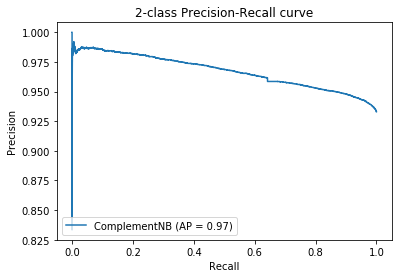

In [131]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(cnb, x_test_vect, y_test)
disp.ax_.set_title('2-class Precision-Recall curve')

## ID Phrases that are mislabeled as accepted when they should be rejected

In [261]:
y_pred = cnb.predict(x_test_vect)

In [276]:
type(y_pred)

numpy.ndarray

In [286]:
examine_df = pd.concat([X_test, y_test], axis=1)
examine_df['pred_rating'] = y_pred

2613

In [326]:
#info that was predicted to be approved but was actually rejected
FP_df = examine_df[(examine_df['rating'] == 0)&(examine_df['pred_rating'] == 1)]

#info that was prediected to be rejected but was actually approved
FN_df = examine_df[(examine_df['rating'] == 1)&(examine_df['pred_rating'] == 0)]

#info that was predicted to be rejected and was rejected
TN_df = examine_df[(examine_df['rating'] == 0)&(examine_df['pred_rating'] == 0)]
#note num645 Yikes what a disappointing article. Written by a woman no less 

# info that was predicted positive and was positive
TP_df = examine_df[(examine_df['rating'] == 1)&(examine_df['pred_rating'] == 1)]

In [329]:
fp_randoms = random.sample(range(2613), 10)

fp_samp = []
for ind, i in enumerate(fp_randoms):
    txt = FP_df.text.values[i]
    fp_samp.append(txt)
    print(f'{ind}: \n{txt} \n')

0: 
11 food stamp and Osamascare recipients gone!  Democrat voters too! 

1: 
The first sentence convinced me that any plan that hickenlooper propounds is not even worth looking at.  Stop all welfare now! 

2: 
In August 2014 the TSX hit an all time high of 15,625.  Today the TSX is 15,182, more than 400 points LOWER.   In Aug 2014 the DJIA hit a high of  about 17,040, today the DJIA is 21,349, more than 4,300 points HIGHER

Do you actually invest, or do you just troll websites and regurgitate numbers which you do not understand? 

3: 
Once again, RD is pouting because someone else's priorities are not what RD would insist they be.

RD has this arrogant belief that he is the sole arbiter of how everyone else should lead their spiritual journeys, how everyone else should arrange their priorities, and what everyone else should believe is important. 

4: 
"I'm sure South Korea and Japan appreciate that at least someone has their back."

Yeah, for sure. SK and Japan can't wait for a nuclea

In [334]:
fn_randoms = random.sample(range(FN_df.rating.value_counts()[1]), 10)

fn_samp = []
for ind, i in enumerate(fn_randoms):
    txt = FN_df.text.values[i]
    fn_samp.append(txt)
    print(f'{ind}: \n{txt} \n')


0: 
“Has a candidate's embarrassing lack of knowledge surrounding basic facts about the world challenged us to better educate ourselves?"

YES! But I have to say that as soon as this election is over I’m going to limit myself to one hour per day of watching/reading news. I don’t need any more than that to keep me informed. Too much news breeds angst. There’s got to be a happy medium between the ostrich with its head in the sand and the Chicken Little with her eyes fixed on a sky that (probably) isn’t falling. 

1: 
Gore did. End of discussion. And Trump has refused to do so BEFORE the first ballot is cast. His praise of Assad and Putin, men who are directly putting the lives of our service men and women at risk RIGHT NOW is unpatriotic and all-but treason. 

2: 
Bloated without Metamucil. 

3: 
AMEN! and again I say, AMEN! 

4: 
Was he a tall, rolly-polly guy with orange hair? 

5: 
Keep dreaming!!! 

6: 
I remember. My mother was one of those. She'd be disgusted with her party today. 

In [339]:
tn_randoms = random.sample(range(TN_df.rating.value_counts()[0]), 10)

tn_samp = []
for ind, i in enumerate(tn_randoms):
    txt = TN_df.text.values[i]
    tn_samp.append(txt)
    print(f'{ind}: \n{txt} \n')


0: 
Canadian politics and lightweight selfie stick little potatoes....TRUMPED again! Even Uncle Tom wiped his boots all over Harper and his current fawning shiny pony of a 'bro' on economic and pipeline matters! Pathetic leadership in this country.Truly a lost decade! 

1: 
All the heroin in this country comes from mexico so maybe when the wall gets built and we round up all the illegal scum, it will stop. The "Hoodrat" obama did nothing, right lefties!
President Trump will get it fixed. 

2: 
There was nothing uncivil about Eddy's post. 

It read something like:

"I have had three successful lobotomies and this column makes perfect sense to me"

Obviously he was using self deprecating humour. 

3: 
All this exercise proves is that Trump is indeed a idiot that was given a snow job by the CIA and Mossad .I hope the world makes usa pay for its war crimes....we wont even get into Isreals  60 odd years of crime against humanity!!! 

4: 
Gotta get rid of nazis miller and gorka too. 

5: 
AN

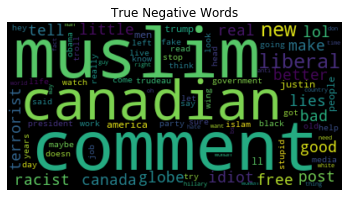

In [347]:
# get indices of words with highest tfidf values
snowball = SnowballStemmer(language = 'english')
port = PorterStemmer()
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', analyzer='word', strip_accents='ascii',sublinear_tf = True)
x = TN_df.text.values
t_vect = vectorizer.fit_transform(x)
features = vectorizer.get_feature_names()

rejected_features = t_vect.toarray().mean(axis=0)
rejected_set = set(np.array(features)[rejected_features.argsort()[::-1][:100]])
plot_word_cloud(' '.join(rejected_set), title = 'True Negative Words', save_fig=True, f_name = 'tn_wordcloud.png')

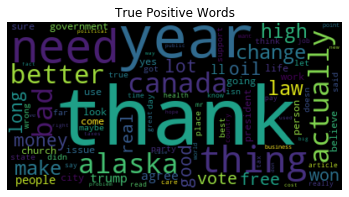

In [348]:
# get indices of words with highest tfidf values
snowball = SnowballStemmer(language = 'english')
port = PorterStemmer()
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', analyzer='word', strip_accents='ascii',sublinear_tf = True)
x = TP_df.text.values
t_vect = vectorizer.fit_transform(x)
features = vectorizer.get_feature_names()

rejected_features = t_vect.toarray().mean(axis=0)
rejected_set = set(np.array(features)[rejected_features.argsort()[::-1][:100]])
plot_word_cloud(' '.join(rejected_set), title = 'True Positive Words', save_fig=True, f_name = 'tp_wordcloud.png')